<a href="https://colab.research.google.com/github/remisoulignac/scm_optim_problems/blob/main/SCM290-GreenVehicleRoutingProblem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ortools
!pip install hyperopt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.6/311.6 kB 28.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 4.24.4 which is incompatible.


# Description of the problem
For this challenge, you will be in charge of deciding the most adequate vehicle routing for the last mile delivery of one day in the city of Xalapa, in Mexico. You will work only with one vehicle and 30 customers for home delivery. It is your job to consider what sequence you must follow to hand out the products to the customers. For your strategy, you may need to consider the distance, product weight and topography in your decisions, since your main indicators are distance, cost and CO2 emissions, being this last one our highest priority. Please consider that each product is assigned to one client and each
client must be visited only once. Historically this route has had daily rate of 50 kg of CO2 emissions, and so, it is desirable to find a better route that will help decrease this number in 10% as a target.
In order to estimate your CO2 emissions, the following formulas and values will be used (Medium duty truck)
:


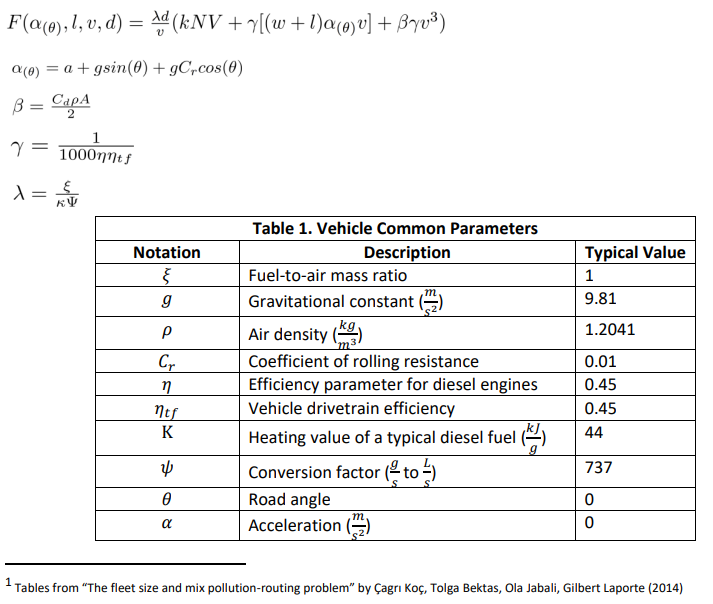


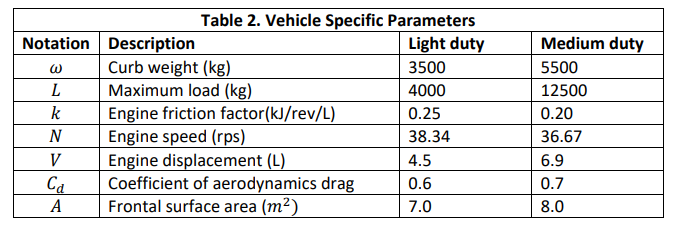

# Solution approach
We apply the modeling of the vehicle routing problem by considering the vehicle consumption as the cost of each arc. We see that for each arc we can precompute a static empty consumption which represents 80% of the fuel consumption. Indeed, the empty curb weight is 5500kg and the delivery load is 1200kg.
<br/>
The remaining fuel consumption depends on the load not yet delivered. This means that the cost function of each arc is like :
 $ cost(Arc, RemainingLoad) = EmptyFuelConsumption(arc) + factor(Arc) \times RemainingLoad $  

I am using Google's ORTools library which has a built-in vehicle routing solver. However, I haven't figured out how to define such a variable arc cost yet.
What we do know is that it is better to deliver heavy items earlier to limit their transportation for the rest of the tour.

So here is the two-level optimization algorithm:
1. A classical VRP optimization model based on the empty fuel consumption costs including the allowed delivery time at each node. I parameterize this model by several control points at which I impose a certain weight of goods to be delivered to the chosen route.
2. A hyperparametric optimization level that will play with the different control points and optimize the overall real fuel consumption of the tour.

In [2]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from hyperopt import fmin, tpe, hp, STATUS_OK, STATUS_FAIL, Trials
import numpy as np
import math

# For MEdium Truck
#    W = 5500    # kg, Curb weight (Medium Duty Truck)
#    L = 12500   # kg, Maximum Load
#    k = 0.20    # kJ/rev/L, Engine friction factor
#    N = 36.67   # rps, Engine speed
#    V = 6.9     # L, Engine displacement
#    Cd = 0.7    # Coefficient of aerodynamics drag
#    A =  8.0    # m^2, Frontal Surface Areal
# For Heavy Truck
CurbWeight = 6350    # kg, Curb weight (Medium Duty Truck)
L = 28000   # kg, Maximum Load
k = 0.20    # kJ/rev/L, Engine friction factor
N = 33      # rps, Engine speed
V = 5       # L, Engine displacement
Cd = 0.7   # Coefficient of aerodynamics drag
A =  3.912    # m^2, Frontal Surface Areal

Xi = 1      # Fuel to Air Mass Ratio
g = 9.81    # m/s^2, Gravitational Constant
Ro = 1.2041 # kg/m^3, Air Density
Cr = 0.01   # Coefficient of rolling resistance
Eta = 0.45  # Efficiency parameter for diesel engines
Eta_tf = 0.45 # Vehicule drivetrain efficiency
Kappa = 44  # kJ/g, Heating value of a typical diesel fuel
Psi = 737   # Conversion factor (g/s to L/s)
Beta = Cd*Ro*A/2

Gamma = 1/(1000*Eta*Eta_tf)
Lambda = Xi/(Kappa*Psi)
FuelToCO2=2.65 # kg/l

# REmarks : formula mix between Heavy Truck and Medium Truck
#   - Heavy Truck for k, N, V
#   - MEdium Truck for W (curb weight)
CurbWeight = 5500

# acceleration(m/s), distance(km), angle(degrees), load (kg), (m/s)
def FuelConsumption(acceleration, distance, slope, total_weight, v):
  v=v/3.6  #convert to m/s
  if (slope >= 0): #Topography model
    degree=slope*0.57
    theta=degree*math.pi/180 # radian
    Alpha=acceleration+g*math.sin(theta)+g*Cr*math.cos(theta)
    return Lambda*distance/v*(k*N*V+Gamma*(total_weight*Alpha*v)+Beta*Gamma*v**3)
  else: #Planar Model
    return Lambda*distance/v*(k*N*V)


def create_data_model(num_vehicles):
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix_meter'] = np.array([
        [ 0, 10.1, 15.6, 12.4, 10.1, 10.2, 13.9, 10.5, 5, 5.3, 2.1, 11.3, 18.7, 5, 2.2, 16.7, 14.5, 9.2, 14.4, 8.4, 13.4, 10.2, 13.3, 15.6, 7.3, 4.1, 8.8, 13.4, 3, 15.7, 11.8 ],
        [ 9.6, 0, 9.2, 9.3, 0.85, 2.9, 4.3, 10, 9.2, 10.1, 9.1, 5.2, 10.7, 9.8, 8.8, 8, 12.4, 2.4, 5.9, 6.1, 4.2, 2.6, 8.8, 9.9, 7.8, 8.2, 6.5, 4.9, 8.8, 7.2, 6.1 ],
        [ 15.7, 9.1, 0, 2.5, 10, 11.7, 10.4, 2.9, 13.8, 9.3, 13.7, 4.3, 2.1, 8.8, 13.4, 7.6, 5, 9, 6.8, 6.3, 11.6, 5.1, 1.3, 1.3, 6.3, 9.1, 5.6, 7, 14.5, 6.3, 3.4 ],
        [ 13.3, 9.1, 2.4, 0, 10.1, 11.8, 10.6, 1, 11.5, 7, 11.4, 4.1, 4.4, 6.5, 11.1, 8.6, 4.4, 9, 7.3, 4, 11.8, 2.8, 1, 1.8, 4, 6.8, 4.3, 7.1, 8.7, 7.3, 3.5 ],
        [ 10, 0.85, 9.9, 9.9, 0, 2.8, 4.9, 10.5, 9.6, 10.6, 9.5, 5.9, 11.4, 10.2, 9.2, 8.7, 13.1, 1.1, 6.6, 6.5, 5.3, 9.2, 9.5, 10.5, 8.3, 8.6, 6.9, 5.6, 9.2, 7.9, 8.3 ],
        [ 9.3, 3.2, 12.4, 11.1, 3.2, 0, 6, 11.5, 8.8, 11.6, 8.7, 8.4, 13.9, 11.3, 8.5, 11.2, 15.6, 5.2, 9.1, 7.5, 5.6, 10.1, 12, 13, 9.2, 9, 7.9, 8.1, 10.2, 10.4, 9.2 ],
        [ 13.3, 4.1, 10.6, 11.1, 5, 6.6, 0, 13.1, 12.9, 13.9, 12.8, 6.6, 10.9, 13.5, 12.5, 6.3, 13.8, 5.4, 4.2, 9.6, 1.1, 11.8, 10.4, 11.3, 11.5, 11.9, 8.8, 4, 12.5, 5.5, 7.9 ],
        [ 12, 10.2, 2.9, 1, 10.4, 12.1, 11.6, 0, 11.9, 6.3, 11.8, 5.1, 4.8, 5.5, 11.5, 9.4, 4.1, 9.4, 8.3, 4.4, 12.8, 3.2, 2, 2.2, 3.7, 7.2, 4.7, 8.1, 8, 8.1, 4.5 ],
        [ 4.4, 9.2, 13.4, 11.5, 9.2, 10.4, 13, 11.9, 0, 8.6, 2.4, 10.1, 15.6, 8.3, 2.4, 15.8, 17.5, 8.7, 13.6, 8.4, 12.6, 10.5, 12.5, 13.5, 9.3, 6, 8.3, 12.5, 7.2, 14.8, 10.9 ],
        [ 6.3, 11.9, 10.5, 7.2, 11.9, 13.1, 14.5, 6.2, 8.7, 0, 6.8, 9.6, 11, 0.75, 6.6, 15.6, 8.6, 11.4, 13.8, 5.4, 14, 5, 8.5, 8.2, 3.1, 3.1, 5.8, 12.1, 2.9, 14.9, 10.5 ],
        [ 2.1, 10, 12.9, 11, 10, 11.3, 13.8, 11.4, 2.4, 6.6, 0, 9.6, 15.1, 6.3, 0.21, 15.5, 15.8, 9.5, 13.3, 7.4, 13.4, 10, 12, 13, 8.6, 5.4, 8.2, 12.2, 4.3, 14.5, 10.4 ],
        [ 11.6, 5.2, 4.4, 3.9, 6.1, 7.8, 6.3, 4.4, 11.2, 9.3, 11.1, 0, 5.6, 8.7, 10.8, 5.9, 7.7, 4.8, 3.8, 4.7, 7.4, 5.1, 4.1, 5.1, 6.3, 9.7, 4, 2.7, 10.3, 4.9, 1.3 ],
        [ 17.3, 10.5, 2.2, 4.4, 11.4, 13.2, 10.8, 4.8, 15.1, 11.8, 19.2, 5.3, 0, 10.8, 14.7, 8.1, 6.9, 10.3, 7.2, 8.3, 12, 6.9, 3.3, 3, 8, 11.1, 7.6, 8, 15.4, 6.8, 4.5 ],
        [ 5.9, 11.6, 9, 6.5, 11.6, 12.8, 13.6, 5.7, 8.3, 0.75, 6.4, 8.7, 11.1, 0, 6.2, 14.6, 10.3, 11, 12.3, 4.7, 13.1, 3.8, 7.5, 8.1, 2.4, 2.7, 5.2, 11.2, 2.5, 13.4, 9.8 ],
        [ 2.1, 10, 12.8, 11, 9.9, 11.2, 13.7, 11.3, 3.2, 6.6, 0.21, 9.5, 15.1, 6.2, 0, 15.4, 15.8, 8, 13.2, 7.3, 13.3, 10, 11.9, 12.9, 8.5, 5.3, 7.7, 12.1, 4.2, 14.4, 10.4 ],
        [ 16.3, 7.8, 7.5, 8.5, 9, 10.7, 6.4, 9.4, 15.8, 15, 15.7, 6.1, 8.2, 14.4, 15.4, 0, 11.5, 9.5, 2.4, 10.4, 7.6, 10.8, 7.7, 8.4, 12, 14.3, 9.7, 3.9, 14.9, 1.3, 6.5 ],
        [ 13.3, 10.9, 3.9, 3, 11.8, 13.6, 12.5, 2.8, 17.3, 9.2, 14.9, 6.1, 5.6, 6.9, 14.6, 10.2, 0, 10.8, 9, 7.6, 13.8, 5.2, 2.8, 2.4, 5.1, 9.8, 7.6, 8.8, 9.6, 8.9, 5.3 ],
        [ 10.5, 2.6, 8.9, 9, 1.1, 3.8, 6.1, 9.7, 9.2, 11, 9.1, 4.9, 10.5, 10.6, 8.8, 9.9, 12.1, 0, 7.4, 6.2, 5.9, 8.3, 8.5, 9.6, 7.9, 8.1, 6.4, 6.4, 9.7, 8.9, 5.8 ],
        [ 14, 5.7, 6.7, 7.2, 6.6, 8.3, 4.1, 8.1, 13.5, 12.8, 13.4, 3.8, 7.3, 12.2, 13.1, 2.3, 10.4, 7.3, 0, 8.2, 5.3, 8.6, 6.8, 7.6, 9.7, 12, 7.4, 1.7, 12.6, 1.4, 3.6 ],
        [ 8.7, 6.4, 5.9, 3.6, 7.3, 9, 8.6, 4, 8.2, 6.2, 8.2, 4.2, 7.3, 6, 7.9, 10.1, 8.2, 6.3, 7.9, 0, 9.2, 2.6, 4.6, 5.5, 2.8, 4.7, 0.65, 6.8, 6, 9.1, 4.6 ],
        [ 12.8, 4.2, 11.7, 11.9, 4.8, 6.1, 1.1, 12.6, 12.4, 13.4, 12.3, 7.7, 12.1, 13, 12, 7.4, 15, 6, 5.3, 9.1, 0, 11.3, 11.5, 12.4, 11.6, 11.4, 9.4, 5.1, 13.3, 6.6, 8.7 ],
        [ 9.5, 8.2, 5.3, 2.8, 9.1, 10.8, 10.3, 3.2, 10.6, 4.4, 10, 4.8, 7.4, 3.8, 9.8, 10.7, 6.1, 8.1, 8.7, 3.1, 11, 0, 3.8, 4.6, 1.2, 4.9, 3.4, 7.5, 6.1, 9.7, 5.3 ],
        [ 14.3, 8.4, 1.4, 1, 9.3, 11.1, 9.9, 2.1, 12.4, 7.9, 12.3, 3.6, 3.6, 7.4, 12, 8, 4.2, 8.3, 6.5, 4.9, 11.3, 3.7, 0, 1.2, 4.9, 7.7, 4.9, 6.3, 8.7, 6.7, 2.8 ],
        [ 14.1, 9.8, 1.3, 1.8, 10.6, 12.4, 11.3, 2.1, 13.6, 8.2, 13.5, 5, 3.2, 7.6, 13.2, 8.4, 2.4, 9.6, 7.5, 6.1, 12.6, 4.7, 1.2, 0, 5.9, 8.9, 6.4, 7.6, 11.8, 7.1, 4.1 ],
        [ 8.6, 8.6, 6.5, 4, 9.5, 11.3, 11.9, 3.7, 9.3, 3.1, 11.2, 6, 8.5, 2.5, 9, 11.9, 6.4, 8.5, 9.8, 3, 11.5, 1.3, 4.9, 6, 0, 3.8, 3.5, 8.7, 4.8, 10.9, 6.5 ],
        [ 4.9, 9.3, 9.5, 7, 9.3, 10.5, 13, 7.3, 6, 3.1, 5.4, 8.5, 11.5, 2.7, 5.2, 14.4, 11.9, 8.7, 12.1, 4.5, 12.6, 5, 7.9, 9, 3.8, 0, 4.9, 11, 1, 13, 9 ],
        [ 8.7, 6, 5.5, 4.6, 6.9, 8.6, 9.3, 5, 8.3, 5.7, 8.2, 3.9, 6.9, 5.9, 7.9, 9.8, 8.7, 5.9, 7.6, 0.65, 8.8, 3.4, 5.1, 6.2, 3.1, 4.8, 0, 6.4, 6.1, 8.7, 4.2 ],
        [ 12.8, 4.9, 7.5, 7.8, 5.8, 7.6, 3.4, 8.1, 12.4, 11.6, 12.3, 3.8, 8.2, 11, 12, 3.8, 11.1, 5.9, 1.4, 7, 4.5, 7.4, 7.5, 8.4, 8.5, 10.9, 6.3, 0, 12.1, 2.7, 4.2 ],
        [ 3.5, 10.6, 10.3, 7.8, 10.6, 10.7, 14, 8, 6.7, 2.8, 4.4, 9.1, 13.1, 2.5, 4.2, 15, 11.7, 10, 12.8, 5.3, 13.6, 6.3, 8.8, 12.1, 4.7, 1, 5.8, 11.6, 0, 14, 9.9 ],
        [ 15, 7.1, 6.2, 7.2, 8, 9.7, 5.5, 8.1, 14.5, 13.7, 14.4, 5.3, 6.9, 13.1, 14.1, 1.3, 10.2, 8.3, 1.3, 9.1, 6.6, 9.5, 6.4, 7.1, 10.7, 13, 8.4, 2.7, 13.6, 0, 5 ],
        [ 11.3, 5.8, 3.4, 3.4, 6.7, 8.5, 7.4, 4.2, 10.8, 9.5, 10.7, 1, 4.5, 8.9, 10.5, 6.5, 6.6, 5.7, 3.6, 4.9, 8.5, 5.3, 3, 4, 6.4, 9.2, 4.2, 3.8, 9.9, 4.9, 0 ],
   ])

    data['slope_matrix_gradient']= np.array([
        [ 0, 0, -0.1, -0.1, -0.05, -0.1, 0, -0.05, -0.05, 0.05, -0.45, 0, -0.05, 0.05, -0.45, 0.15, -0.55, -0.1, 0.05, 0.3, 0.1, 0.05, -0.05, -0.05, -0.1, -0.05, 0.2, 0.05, 0.05, 0.05, 0.05 ],
        [ -0.1, 0, 0.05, 0.2, -0.35, -0.15, -0.15, 0.2, 0, 0.15, -0.1, 0.05, 0.1, 0.15, -0.1, 0.25, 0.1, -0.4, 0.05, 0.35, 0.1, 0.35, 0.2, 0.2, 0.15, 0.1, 0.25, 0.05, -0.05, 0.1, 0.1 ],
        [ -0.05, -0.05, 0, 0.3, -0.1, -0.05, -0.15, -0.1, -0.05, -0.05, -0.1, -0.2, -0.35, -0.1, -0.05, 0.4, 0.05, -0.1, 0.05, -0.45, 0, -0.1, 0.45, 0.5, -0.4, -0.2, 0.3, 0, -0.05, 0.15, -0.2 ],
        [ 0, -0.15, -0.6, 0, -0.1, -0.15, -0.2, 0.15, 0, 0, -0.05, -0.3, -0.5, 0, -0.05, 0.2, -0.15, -0.2, -0.25, -0.4, -0.05, 0.15, -0.15, -0.35, -0.3, 0, 0.3, 0, 0.05, 0, -0.25 ],
        [ -0.05, 0.35, 0.1, 0.15, 0, -0.05, -0.15, 0.1, -0.1, 0.1, -0.1, 0, -0.1, 0.1, -0.1, -0.2, -0.1, -0.3, 0.05, 0.3, 0.05, 0.25, 0.15, 0.15, 0.05, 0.05, 0.2, 0, -0.05, 0.05, 0.1 ],
        [ 0, 0.05, 0.05, 0.15, -0.1, 0, 0.05, 0.1, 0, 0.05, -0.05, 0, -0.1, 0.1, 0.05, 0.2, 0, -0.15, 0.05, 0.3, -0.15, 0.25, 0.25, 0.15, 0.05, 0, 0.25, -0.05, 0.05, 0.05, 0.05 ],
        [ -0.1, -0.05, 0.05, 0.1, 0.1, -0.1, 0, 0.05, -0.05, 0.1, -0.1, -0.1, -0.3, 0.1, -0.1, 0, 0.1, -0.25, -0.1, 0.25, 0.05, 0.15, 0.1, 0.1, 0.15, 0, 0.15, -0.2, 0, 0.05, 0 ],
        [ -0.05, -0.15, -0.65, -0.15, -0.1, -0.15, -0.4, 0, 0, 0.1, -0.1, -0.2, -0.25, 0.05, -0.1, 0.05, -0.05, -0.15, -0.25, -0.3, -0.15, 0.3, -0.45, -0.1, 0.15, -0.05, 0.4, 0.05, 0.1, -0.1, -0.15 ],
        [ 0.1, 0, -0.1, 0, -0.05, -0.1, -0.05, -0.05, 0, 0, -0.2, -0.05, -0.05, 0, -0.15, 0.2, 0, -0.1, 0, 0.3, 0.05, 0.15, 0.1, 0, -0.05, -0.1, 0.2, -0.05, 0, 0.05, 0.05 ],
        [ -0.15, -0.05, 0.25, 0.15, -0.05, -0.1, -0.2, -0.15, -0.05, 0, -0.2, 0.3, -0.05, -0.5, -0.2, 0.25, -0.05, -0.2, 0.25, -0.15, -0.05, 0.3, 0.35, -0.05, -0.25, -0.45, -0.2, 0.45, -0.2, 0.25, 0.25 ],
        [ 0.25, 0, -0.05, 0.05, -0.05, -0.1, -0.05, 0, 0.05, 0.05, 0, -0.05, -0.1, 0, -0.3, 0.15, 0, -0.05, 0.05, 0.35, 0.05, 0.05, -0.05, 0, -0.05, -0.1, 0.25, -0.05, 0, 0.05, 0.05 ],
        [ 0, 0.2, 0, 0.25, 0.15, 0.05, 0.2, 0.25, 0.1, -0.15, 0.05, 0, -0.25, -0.2, 0.1, 0.45, 0.1, 0, 0.15, 0.6, 0.2, 0.35, 0.3, 0.25, -0.1, 0.15, 0.45, 0.5, 0.05, 0.2, 0.2 ],
        [ 0, 0.1, 0.1, 0.25, 0.15, 0.1, 0.2, 0.05, 0.05, -0.1, -0.05, 0.05, 0, -0.1, -0.05, 0.5, -0.05, -0.35, 0.2, -0.3, 0.2, 0.05, 0.3, 0.25, -0.25, -0.1, 0.2, 0.15, -0.05, 0.35, 0.2 ],
        [ -0.1, 0.05, 0.3, 0.1, -0.05, -0.1, -0.25, -0.1, -0.05, 0, -0.2, 0.35, -0.05, 0, -0.1, 0.25, -0.05, -0.3, -0.05, 0, -0.1, -0.4, 0.4, -0.05, -0.6, -0.35, -0.05, -0.15, 0, 0.25, 0.2 ],
        [ 0.25, -0.05, -0.05, 0, -0.05, -0.1, -0.05, 0, 0, 0.05, -0.45, -0.05, -0.05, 0.05, 0, 0.15, 0, -0.05, 0, 0.35, 0.05, 0.05, 0, 0, -0.05, -0.1, 0.25, -0.05, -0.05, 0.05, 0.05 ],
        [ -0.2, -0.25, -0.45, -0.35, -0.25, -0.25, 0.05, -0.3, -0.15, -0.2, -0.15, -0.35, -0.75, -0.2, -0.15, 0, 0.3, -0.35, 0, 0.05, 0.05, 0, -0.35, -0.4, -0.1, -0.1, -0.05, 0.1, -0.2, 1.45, -0.1 ],
        [ -0.05, -0.2, -0.55, -0.35, -0.2, -0.2, -0.25, -0.15, 0, -0.05, -0.1, -0.35, -0.35, -0.05, -0.1, 0.05, 0, -0.2, -0.3, 0, -0.15, -0.1, -0.35, -0.4, -0.25, -0.1, 0, -0.15, -0.05, -0.1, -0.2 ],
        [ -0.05, 0.35, 0.15, 0.3, 0.2, 0.05, 0, 0.25, 0, 0.15, -0.05, 0.15, -0.1, 0.2, 0, 0.25, 0.15, 0, 0, 0.55, 0.15, 0.4, 0.3, 0.25, 0.2, 0, 0.35, 0.1, 0, 0.1, 0.2 ],
        [ -0.05, 0, -0.2, 0.15, 0, -0.05, 0.05, 0.1, 0, -0.05, 0, -0.25, -0.45, -0.1, 0, -0.05, 0.05, -0.15, 0, 0.35, 0.05, 0.2, -0.05, -0.15, 0.3, 0.05, 0.25, -0.15, 0, -0.1, 0.05 ],
        [ -0.2, -0.3, -0.5, -4, -0.25, -0.3, -0.45, -0.55, -0.2, -0.55, -0.25, 0.05, -0.2, -0.6, -0.25, 0.15, -0.3, -0.45, -0.1, 0, -0.2, -0.35, 0, 0.05, 0.6, 0.1, -0.35, 0.2, 0.25, 0.05, -0.2 ],
        [ -0.15, -0.2, 0, 0.05, -0.15, -0.2, -0.4, 0.05, -0.1, 0.05, -0.15, -0.1, -0.35, 0.05, -0.35, -0.05, 0.05, -0.35, -0.25, 0.2, 0, 0.1, 0.05, 0.05, 0.1, -0.05, 0.1, -0.35, -0.05, -0.05, -0.05 ],
        [ -0.1, -0.15, 0, -0.25, -0.05, -0.15, -0.3, -0.3, -0.15, -0.35, -0.15, 0.25, -0.05, -0.45, -0.15, 0.15, -0.25, -0.3, 0, 0.05, -0.15, 0, 0.25, 0.15, -0.1, 0.45, 0, -0.1, -0.2, 0.05, 0 ],
        [ -0.05, -0.2, -0.7, 0, -0.15, -0.2, -0.25, -0.2, -0.05, -0.4, -0.1, -0.4, -0.5, -0.5, -0.05, 0.15, -0.15, -0.25, -0.3, -0.65, -0.1, -0.3, 0, -0.05, -0.65, -0.25, 0.05, -0.05, 0, 0, -0.35 ],
        [ -0.05, -0.15, -0.4, 0, -0.15, -0.15, -0.2, 0.1, 0, -0.1, -0.05, -0.35, -0.35, -0.05, -0.1, 0.25, -0.1, -0.2, -0.3, -0.7, -0.1, -0.3, -0.1, 0, -0.1, -0.1, -0.2, -0.1, 0, 0.05, -0.35 ],
        [ -0.05, -0.2, 0.45, 0.4, -0.1, -0.1, -0.4, -0.1, 0.05, 0.3, -0.15, 0.75, -0.05, 0.25, -0.15, 0.35, -0.2, -0.3, 0.3, -0.5, -0.15, 0.1, 0.8, 0.05, 0, 0.4, -0.3, 0.7, 0.25, 0.35, 0.35 ],
        [ 0.1, 0.05, -0.05, -0.45, 0.05, -0.05, -0.1, -0.05, 0.1, 0.3, -0.05, -0.15, -0.1, 0.3, 0, 0.1, 0, -0.2, -0.05, -0.05, 0, -0.55, -0.1, -0.05, 0.5, 0, -0.15, -0.1, -0.15, -0.05, 0 ],
        [ -0.2, -0.35, -0.4, -0.5, -0.3, -0.3, -0.5, -0.5, -0.2, 0.3, -0.25, 0.1, -0.2, 0.25, -0.2, 0.25, -0.25, -0.65, -0.4, 0.25, -0.25, -0.25, 0, 0.1, 0.15, 0.15, 0, -0.4, 0.15, 0.1, -0.1 ],
        [ -0.05, -0.1, 0.1, 0.15, -0.05, -0.1, -0.2, 0.1, 0.05, -0.15, 0, 0.15, -0.15, -0.15, 0.1, 0.1, 0.05, -0.1, 0.1, 0.4, 0, 0.25, 0.2, 0.15, 0, 0.1, 0.3, 0, 0.05, 0.4, 0.35 ],
        [ 0.05, 0, -0.15, -0.05, 0, -0.05, 0.05, -0.25, 0, 0.05, -0.05, 0, -0.1, -0.05, -0.05, 0.2, -0.1, -0.1, 0.05, 0.05, 0.1, 0.05, -0.1, -0.1, -0.3, -0.05, -0.05, 0, 0, 0.05, 0.05 ],
        [ -0.1, -0.1, -0.35, -0.15, -0.1, -0.1, -0.1, -0.15, -0.05, -0.2, -0.05, -0.2, -0.6, -0.15, -0.05, -1.45, 0.25, -0.25, 0.05, 0.25, 0, 0.1, -0.2, -0.25, -0.05, -0.05, 0.1, 0.05, -0.05, 0, -0.05 ],
        [ 0.05, -0.05, -0.05, 0.25, -0.1, -0.1, -0.15, 0.15, -0.05, -0.2, -0.1, -0.15, -0.35, -0.2, -0.05, 0.25, 0.05, -0.05, -0.2, 0.45, 0.05, 0.3, 0.3, 0.2, -0.05, 0, 0.45, 0.3, -0.05, -0.05, 0 ],
    ])

    data['speed']=25 #km/h
    data['time_matrix'] = data['distance_matrix_meter'] / data['speed'] * 60
    data['demands'] = [ 0, 0.330693, 90.7184, 22.6796, 27.2155, 27.2155, 54.4311, 4.53592, 0.330693, 1.1, 90.7185, 31.7515, 0.907185, 49.8952, 45.3592, 40.8233, 3.62874, 113.398, 13.6078, 77.1107, 3.17515, 56.699, 90.7185, 3.62874, 49.8952, 90.7184, 22.6796, 0.330693, 113.398, 0.330693, 45.3592 ]
    data['total_demand']=np.sum(data['demands'])
    data['delivery_time']= [ 0, 5, 16, 7, 7, 10, 15, 7, 5, 5, 25, 15, 5, 8, 18, 15, 10, 25, 8, 15, 5, 15, 22, 10, 8, 18, 10, 5, 25, 5, 20 ]

    data['time_windows'] = [
      (0, 0),
      (0, 120),
      (0, 300),
      (0, 600),
      (0, 120),
      (0, 240),
      (0, 600),
      (0, 360),
      (0, 600),
      (60, 660),
      (0, 600),
      (0, 600),
      (0, 300),
      (0, 600),
      (0, 600),
      (180, 600),
      (0, 600),
      (0, 240),
      (180, 600),
      (0, 600),
      (0, 600),
      (0, 600),
      (240, 480),
      (0, 360),
      (0, 600),
      (0, 510),
      (0, 540),
      (420, 600),
      (0, 540),
      (180, 480),
      (0, 330),
    ]

    data['empty_truck_fuel_consumption_matrix' ]=np.empty(data['distance_matrix_meter'].shape)
    for i in range(data['distance_matrix_meter'].shape[0]):
      for j in range(data['distance_matrix_meter'].shape[1]):
        data['empty_truck_fuel_consumption_matrix' ][i,j]= \
          FuelConsumption(0, data['distance_matrix_meter'][i,j]*1000, data['slope_matrix_gradient'][i,j], CurbWeight-data['demands'][i], data['speed'])

    data['empty_truck_fuel_consumption_matrix' ]= (data['empty_truck_fuel_consumption_matrix' ]*1000).astype(int)
    data['depot'] = 0
    return data

In [3]:
# delivery_checkpoints = list of (index, min_delivered_quantity)
def solve(data, delivery_checkpoints=[], ignored_time_constraint_nodes=[], num_vehicles=1, allowed_waiting_time_at_delivery=0, force_tour_debut_immediately=True, vehicle_capacity=[9999]):
    """Solve the CVRP problem."""

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix_meter']),
                                           num_vehicles, data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)
    model_parameters = pywrapcp.DefaultRoutingModelParameters()
    model_parameters.max_callback_cache_size = 2 * len(data["demands"]) * len(data["demands"])
    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager, model_parameters)

    def get_solution_details(data, manager, routing, solution):
      vehicles=[]
      time_dimension = routing.GetDimensionOrDie('Time')
      for vehicle_id in range(num_vehicles):
        index = routing.Start(vehicle_id)
        start_weight=data['total_demand']
        fuel_consumption = 0
        delivered_weight = 0
        node_index = manager.IndexToNode(index)
        nodes=[]
        node_times=[]
        while not routing.IsEnd(index):
            nodes.append(node_index)
            time_var=time_dimension.CumulVar(index)
            node_times.append((solution.Min(time_var),solution.Max(time_var)))
            delivered_weight += data['demands'][node_index]
            previous_node_index=node_index
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            node_index = manager.IndexToNode(index)
            step_fuel_consumption = FuelConsumption(
                0,
                data['distance_matrix_meter'][previous_node_index,node_index]*1000,
                data['slope_matrix_gradient'][previous_node_index,node_index],
                CurbWeight+start_weight-delivered_weight,
                data['speed'])
            fuel_consumption+=step_fuel_consumption
        vehicles.append({
            "vehicle_id":vehicle_id,
            "CO2_emission":fuel_consumption*FuelToCO2,
            "fuel_consumption":fuel_consumption,
            "nodes":nodes,
            "node_times":node_times
        })
      return vehicles

    # Create and register a transit callback.
    def empty_truck_fuel_consumption_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return round(data['empty_truck_fuel_consumption_matrix' ][from_node][to_node])

    transit_callback_index = routing.RegisterTransitCallback(empty_truck_fuel_consumption_callback)
    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Capacity constraint.
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return round(data['demands'][from_node])

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        vehicle_capacity,  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')

    # the truck is obliged to have unloaded a certain quantity at different control points
    for delivery_checkpoint in delivery_checkpoints:
      routing.GetMutableDimension('Capacity').SetCumulVarSoftLowerBound(delivery_checkpoint[0], delivery_checkpoint[1], 100)

    # Create and register a transit callback.
    def time_callback(from_index, to_index):
        """Returns the travel time between the two nodes."""
        # Convert from routing variable Index to time matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        total_time= round(data['time_matrix'][from_node][to_node]+data['delivery_time'][to_node])
        return total_time
    time_callback_index = routing.RegisterTransitCallback(time_callback)

    # Add Time Windows constraint.
    time = 'Time'
    routing.AddDimension(
        time_callback_index,
        allowed_waiting_time_at_delivery,  # allow waiting time
        24*600,  # maximum time per vehicle
        force_tour_debut_immediately,  # force start cumul to zero.
        time)
    time_dimension = routing.GetDimensionOrDie(time)
    # Add time window constraints for each location except depot.
    for location_idx, time_window in enumerate(data['time_windows']):
        if location_idx == data['depot']:
            continue
        index = manager.NodeToIndex(location_idx)
        if (not location_idx in ignored_time_constraint_nodes):
          time_dimension.CumulVar(index).SetRange(time_window[0], time_window[1])


    # Add time window constraints for each vehicle start node.
    depot_idx = data['depot']
    for vehicle_id in range(num_vehicles):
        index = routing.Start(vehicle_id)
        time_dimension.CumulVar(index).SetRange(
            data['time_windows'][depot_idx][0],
            data['time_windows'][depot_idx][1])

    # Instantiate route start and end times to produce feasible times.
    for i in range(num_vehicles):
        routing.AddVariableMinimizedByFinalizer(
            time_dimension.CumulVar(routing.Start(i)))
        routing.AddVariableMinimizedByFinalizer(
            time_dimension.CumulVar(routing.End(i)))


    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.GLOBAL_CHEAPEST_ARC)
    search_parameters.time_limit.FromSeconds(100)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
      return get_solution_details(data, manager, routing, solution)
    else:
      return None

In [4]:
def find_solution(num_vehicles, max_evals, num_checkpoints, num_ignored_time_constraints, allowed_waiting_time_at_delivery=0, force_tour_debut_immediately=True):
  # Instantiate the data problem.
  data = create_data_model(num_vehicles=1)

  quantization=5
  search_space = {
    **{ f'checkpoint{cp}_index':hp.choice(f'checkpoint{cp}_index', range(len(data['demands']))) for cp in range(num_checkpoints) },
    **{ f'checkpoint{cp}_delivered_quantity':hp.quniform(f'checkpoint{cp}_delivered_quantity', 1, data["total_demand"], quantization) for cp in range(num_checkpoints) },
    **{ f'ignored_time_constraint_node{n}':hp.choice(f'ignored_time_constraint_node{n}', range(len(data['demands']))) for n in range(num_ignored_time_constraints) }
  }

  def objective(hyperparams):
    sol = solve(data,
          [(int(hyperparams[f"checkpoint{cp}_index"]), int(hyperparams[f"checkpoint{cp}_delivered_quantity"])) for cp in range(num_checkpoints)],
          [int(hyperparams[f"ignored_time_constraint_node{n}"]) for n in range(num_ignored_time_constraints)])
    if not sol is None:
        return {
            'loss': sum(vehicle["CO2_emission"] for vehicle in sol),
            'status':STATUS_OK,
            'attachments':  {"solution": sol}
        }
    else:
      return {'status': STATUS_FAIL}

  trials = Trials()
  best = fmin(objective,
      space=search_space,
      algo=tpe.suggest,
      max_evals=max_evals,
      trials=trials)

  print(trials.best_trial["misc"]["vals"])
  print(trials.trial_attachments(trials.best_trial)['solution'])

In [ ]:
find_solution(num_vehicles=1, max_evals=250, num_checkpoints=3, num_ignored_time_constraints=3)

  0%|          | 0/250 [00:00<?, ?trial/s, best loss=?]

In [ ]:
# find_solution(num_vehicles=2, max_evals=25, allowed_waiting_time_at_delivery=60, force_tour_debut_immediately=False)

In [ ]:
# SAVED RUNS
# these results where obtain with num_evals=100
#[{'vehicle_id': 0, 'CO2_emission': 42.02632968726531, 'fuel_consumption': 15.8589923348171, 'nodes': [0, 14, 10, 8, 5, 4, 1, 17, 11, 30, 18, 29, 15, 12, 2, 23, 16, 7, 3, 22, 21, 24, 13, 9, 28, 25, 19, 26, 27, 6, 20]}]
#[{'vehicle_id': 0, 'CO2_emission': 41.25357424562206, 'fuel_consumption': 15.567386507781912, 'nodes': [0, 14, 10, 8, 17, 4, 1, 5, 20, 6, 18, 29, 15, 30, 12, 2, 7, 3, 22, 23, 16, 21, 13, 9, 28, 25, 19, 26, 27, 11, 24]}]
#[{'vehicle_id': 0, 'CO2_emission': 42.21072623883676, 'fuel_consumption': 15.928575939183686, 'nodes': [0, 25, 28, 5, 4, 1, 17, 11, 30, 12, 2, 23, 16, 7, 3, 22, 21, 9, 13, 24, 19, 26, 20, 6, 27, 18, 29, 15, 8, 14, 10]}]
#[{'vehicle_id': 0, 'CO2_emission': 40.45114333611414, 'fuel_consumption': 15.26458239098647, 'nodes': [0, 28, 25, 17, 4, 1, 5, 20, 6, 11, 30, 12, 2, 23, 16, 7, 3, 22, 21, 9, 13, 24, 19, 26, 27, 18, 29, 15, 8, 14, 10]}]

#{'checkpoint1_delivered_quantity': [450.0], 'checkpoint1_index': [29.0], 'checkpoint2_delivered_quantity': [135.0], 'checkpoint2_index': [5.0], 'checkpoint3_delivered_quantity': [1040.0], 'checkpoint3_index': [14.0]}
#[{'vehicle_id': 0, 'CO2_emission': 40.503347856063826, 'fuel_consumption': 15.284282209835405, 'nodes': [0, 17, 4, 1, 5, 20, 6, 11, 30, 12, 2, 23, 16, 7, 3, 22, 21, 9, 25, 28, 13, 24, 19, 26, 27, 18, 29, 15, 8, 10, 14], 'node_times': [(0, 0), (47, 47), (56, 56), (63, 63), (79, 79), (97, 97), (114, 114), (144, 144), (167, 167), (182, 182), (203, 203), (216, 216), (231, 231), (244, 244), (253, 253), (277, 277), (300, 300), (315, 315), (340, 340), (367, 367), (381, 381), (394, 394), (416, 416), (427, 427), (447, 447), (458, 458), (466, 466), (484, 484), (526, 526), (556, 556), (574, 574)]}]

#97% on time delivery
# {'checkpoint0_delivered_quantity': [320.0], 'checkpoint0_index': [25], 'checkpoint1_delivered_quantity': [145.0], 'checkpoint1_index': [24], 'checkpoint2_delivered_quantity': [950.0], 'checkpoint2_index': [4], 'ignored_time_constraint_node0': [8], 'ignored_time_constraint_node1': [27], 'ignored_time_constraint_node2': [23]}
# [{'vehicle_id': 0, 'CO2_emission': 36.28463370103291, 'fuel_consumption': 13.692314604163363, 'nodes': [0, 10, 14, 17, 4, 1, 5, 20, 6, 27, 18, 29, 15, 11, 30, 12, 2, 23, 16, 7, 3, 22, 21, 24, 19, 26, 8, 25, 28, 13, 9], 'node_times': [(0, 0), (30, 30), (48, 48), (92, 92), (101, 101), (108, 108), (124, 124), (142, 142), (159, 159), (173, 173), (184, 184), (192, 192), (210, 210), (239, 239), (262, 262), (277, 277), (298, 298), (311, 311), (326, 326), (339, 339), (348, 348), (372, 372), (395, 395), (405, 405), (427, 427), (438, 438), (462, 462), (494, 494), (521, 521), (535, 535), (541, 541)]}]


# output for ease of copy/pasting into the excel simulator
for i in [10, 14, 17, 4, 1, 5, 20, 6, 27, 18, 29, 15, 11, 30, 12, 2, 23, 16, 7, 3, 22, 21, 24, 19, 26, 8, 25, 28, 13, 9]:
  print(i)